In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers import Dense, Activation, Lambda, concatenate
from keras.optimizers import SGD

from keras.datasets import mnist

from keras.utils import np_utils

from keras import backend as K
from keras import metrics

Using TensorFlow backend.


In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

x_train = x_train/255
x_test = x_test/255

In [6]:
enc_1 = Dense(100, activation='sigmoid')
enc_mean = Dense(2)
enc_log_var = Dense(2)
dec_2 = Dense(100, activation='sigmoid')
dec_1 =  Dense(784, activation='sigmoid')

In [7]:
x = Input(shape=(784,))
enc_x = enc_1(x)
z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [8]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0, stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [9]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [10]:
dec_x = dec_2(z)
x_recons = dec_1(dec_x)

# 2.VAE

In [11]:
VAE = Model(x, x_recons)

In [12]:
VAE.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          78500       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            202         dense_1[0][0]                    
____________________________________________________________________________________________

In [13]:
def vae_loss(x, x_recon):
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

In [14]:
VAE.compile(loss=vae_loss, optimizer='Nadam')

In [15]:
VAE.load_weights('VAE_handwriting_model_weights.h5')

# 2.2VAE submodels

In [16]:
VAE_Encoder = Model(x, z_mean)
VAE_Encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [17]:
h_input = Input(shape=(2,))
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))
VAE_Decoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_5 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


In [18]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的latent 表示為 %s " %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 22832 圖的latent 表示為 [[-0.18579179 -0.14304444]] 


In [19]:
idices = np.random.randint(x_test.shape[0], size=1000)
latents = VAE_Encoder.predict(x_test[idices])

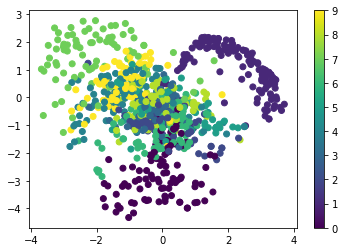

In [20]:
plt.scatter(latents[:, 0], latents[:, 1], c=y_test[idices])
plt.colorbar()
plt.show()

In [21]:
def normalize_to_unit(x):
    x -= x.min()
    x /= x.max()
    return x

In [22]:
n = 15
digit_size = 28
VAE_figure = np.zeros((digit_size * n, digit_size * n))
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)

for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi,yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n - i - 1) * digit_size: (n - i) * digit_size,
            j * digit_size: (j + 1) * digit_size] = normalize_to_unit(digit)

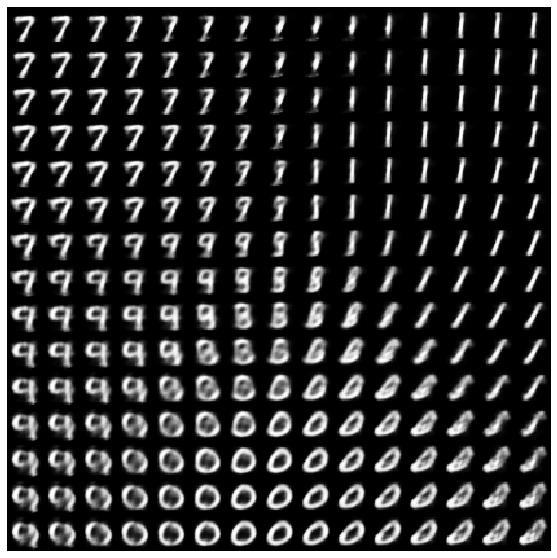

In [23]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys_r')
plt.axis('off')
plt.show()